In [1]:
import numpy as np;import pandas as pd;import os,sys;
from sklearn.model_selection import train_test_split,KFold
from utils import read_data,seq2kmer,read_fasta;from collections import Counter
from sklearn.utils import shuffle;from pycaret.classification import *
import torch;from torch import nn, Tensor;import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset,DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE=128
mod_type="m6Am"# just for exsample
train_type="normal"
random_seed=123


In [ ]:
use_fp16="--fp16"#if you don't install apex,please delete this line, if you want to use apex,please install apex first following the instructions on DNABERT GitHub Repository
#Please Download the model file from the url in readme.md and put it in the same directory as this script

## Fintune Pre-trained Model

In [7]:
if train_type=="normal":
    all_data=read_fasta("./dataset/CD-fasta/"+mod_type+".fasta")
    test_data=read_data("./dataset/test",mod_type)
    train_data, val_data = train_test_split(all_data, test_size=0.2, random_state=random_seed)    
    def get_bert_data():
        if os.path.exists("./dataset/bert/classic/"+mod_type):
            print("目录已存在")
        else:
            os.mkdir("./dataset/bert/classic/"+mod_type)
        df=train_data.copy(deep=True)
        df["sequence"]=df["sequence"].apply(seq2kmer)
        df.to_csv("./dataset/bert/classic/"+mod_type+"/train.tsv",sep="\t",index=None)
        df=val_data.copy(deep=True)
        df["sequence"]=df["sequence"].apply(seq2kmer)
        df.to_csv("./dataset/bert/classic/"+mod_type+"/dev.tsv",sep="\t",index=None)
    get_bert_data()
    if mod_type=="hm6A" or mod_type=="Atol":
        eph=5
    else:
        eph=25
    !python ./DNABERT/examples/run_finetune.py   --early_stop 10 --model_type dna  --tokenizer_name=dna3  --model_name_or_path ./models/bert/{mod_type}  --task_name dnaprom  --do_train  --do_eval  --data_dir ./dataset/bert/classic/{mod_type} --max_seq_length 101  --per_gpu_eval_batch_size=32    --per_gpu_train_batch_size=32   --learning_rate 3e-5  --num_train_epochs {str(eph)}  --output_dir ./results/your_models/bert/classic/{mod_type}  --evaluate_during_training  --logging_steps 100  --save_steps 100  --warmup_percent 0.1  --hidden_dropout_prob 0.1  --overwrite_output  --weight_decay 0.01  --n_process 40  {use_fp16}


目录已存在
12/20/2023 22:23:35 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: True
12/20/2023 22:23:35 - INFO - transformers.configuration_utils -   loading configuration file ./models/bert/m6Am/config.json
12/20/2023 22:23:35 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": "dnaprom",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_be

In [8]:
from DNABERT.examples.transformers.data.processors.glue import DnaPromProcessor,glue_convert_examples_to_features
from DNABERT.examples.transformers.data.processors.utils import InputExample
from DNABERT.examples.run_finetune import TensorDataset
from transformers import BertConfig,    DNATokenizer,    BertForSequenceClassification
bert_train=pd.read_csv("./results/your_models/bert/classic/"+mod_type+"/eval_results.txt",sep=" ",header=None)
bert_train['sum'] = bert_train[1] + bert_train[2]
max_row = bert_train.loc[bert_train['sum'].idxmax()]
model_name = "./results/your_models/bert/classic/"+mod_type+"/checkpoint-"+str((max_row.name+1)*100)
bert=BertForSequenceClassification.from_pretrained(model_name)
def tensor2np(tensor_list):
    array_list = [tensor.cpu().numpy() for tensor in tensor_list]
    array = np.concatenate(array_list, axis=0)
    return array
def tensor2np2(tensor_list):
    array_list = [tensor.detach().cpu().numpy() for tensor in tensor_list]
    array = np.concatenate(array_list, axis=0)
    return array
import itertools
from collections import Counter
def get_feature(df):
    def CKSNAP(sequence, gap=3):
        AA = 'ACGT'
        code = []
        aaPairs = []
        for aa1 in AA:
            for aa2 in AA:
                aaPairs.append(aa1 + aa2)

        header = []
        for g in range(gap + 1):
            for aa in aaPairs:
                header.append(aa + '.gap' + str(g))
        #encodings.append(header)


        for g in range(gap + 1):
            myDict = {}
            for pair in aaPairs:
                myDict[pair] = 0
            sum = 0
            for index1 in range(len(sequence)):
                index2 = index1 + g + 1
                if index1 < len(sequence) and index2 < len(sequence) and sequence[index1] in AA and sequence[
                    index2] in AA:
                    myDict[sequence[index1] + sequence[index2]] = myDict[sequence[index1] + sequence[index2]] + 1
                    sum = sum + 1
            for pair in aaPairs:
                code.append(myDict[pair] / sum)
        return code
    def Kmer(sequence,k=3):
        kmers = []
        for i in range(len(sequence) - k + 1):
            kmers.append(sequence[i:i + k])
        code=[];header = [];count = Counter()
        count.update(kmers)
        for key in count:
            count[key] = count[key] / len(kmers)
        NA = 'ACGT'
        for kmer in itertools.product(NA, repeat=3):
            header.append(''.join(kmer))
        for j in range(len(header)):
                    if header[j] in count:
                        code.append(count[header[j]])
                    else:
                        code.append(0)
        return code
    def binary(s):
        Encode = {'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'U':[0,0,0,1],'T':[0,0,0,1],'N':[0,0,0,0]}
        return np.array([Encode[x] for x in s])
    def cal(c,cb,i):
        bases ={'A':[1,1,1], 'C':[0,1,0], 'G':[1,0,0,], 'T':[0,0,1],'U':[0,0,1],'N':[0,0,0]}
        p=[]
        p=bases[c]
        p.append(np.round(cb/float(i+1),2))
        return(p)
    def ENAC(sequence, window=5):
        AA =  'ACGT'
        code=[]
        sequence="NN"+sequence+"NN"
        for j in range(len(sequence)):
            if j < len(sequence) and j + window <= len(sequence):
                count = Counter(sequence[j:j + window])
                for key in count:
                    count[key] = count[key] / len(sequence[j:j + window])
                for aa in AA:
                    code.append(count[aa])
        return code
    def EIIP(s):
        dic = {'A':[0.1260],'C':[0.1340],'G':[0.0806],'T':[0.1335],'U':[0.1335],'N':[0]}
        return np.array([dic[x] for x in s])
    def calculate_chem(s):
        p=f=list()
        cba=cbc=cbt=cbg=0
        for i,c in enumerate(s):
            if c=='A':
                cba+=1
                p=cal(c,cba,i)
            elif c=='T':
                cbt+=1
                p=cal(c,cbt,i)
            elif c=='U':
                cbt+=1
                p=cal(c,cbt,i)
            elif c=='C':
                cbc+=1
                p=cal(c,cbc,i)
            elif c=='G':
                cbg+=1
                p=cal(c,cbg,i)
            else:
                p=[0,0,0,0]
            f.append(p)
        return(f)
    one_hot=[];chem=[];eiip=[];enac=[];_kmer=[];cksnap=[]
    for i in df.sequence.values:
        one_hot.append(binary(i))
        chem.append(calculate_chem(i))
        eiip.append(EIIP(i))
        enac.append(np.array(ENAC(i,window=5)).reshape(4,-1).T)
        _kmer.append(Kmer(i,k=3))
        cksnap.append(CKSNAP(i,gap=3))
    one_hot=np.array(one_hot)
    chem=np.array(chem)
    eiip=np.array(eiip)
    enac=np.array(enac)
    _kmer=np.array(_kmer)
    cksnap=np.array(cksnap)
    return one_hot,chem,eiip,enac,_kmer,cksnap
def create_examples(df, set_type='dev'):
    examples = [];i=1
    for line in df.values:
        guid = "%s-%s" % (set_type, i)
        text_a = seq2kmer(line[0])
        label = str(line[1])
        examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        i=i+1
    return examples
def load_and_cache_examples(df):

    tokenizer = DNATokenizer.from_pretrained(model_name)
    processor = DnaPromProcessor()
   
    label_list = processor.get_labels()
    examples = (create_examples(df))   

    max_length = 101
    pad_on_left = 0
    pad_token = tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0]
    
    features = glue_convert_examples_to_features(
    examples,
    tokenizer,
    label_list=label_list,
    max_length=max_length,
    output_mode="classification",
    pad_on_left=pad_on_left, 
    pad_token=pad_token,
    pad_token_segment_id=0)
            
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
    return all_input_ids, all_attention_mask, all_token_type_ids, all_labels
class MyDataset(Dataset):
        def __init__(self,df):
            W,X,Y,Z,M,N=get_feature(df)
            self.w=torch.tensor(W,dtype=torch.float32)
            self.x=torch.tensor(X,dtype=torch.float32)
            self.y=torch.tensor(Y,dtype=torch.float32)
            self.z=torch.tensor(Z,dtype=torch.float32)
            self.m=torch.tensor(M,dtype=torch.float32)
            self.n=torch.tensor(N,dtype=torch.float32)
            self.len=X.shape[0] 
            self.label=df.label.values
            self.token=load_and_cache_examples(df)
        def __getitem__(self, index):
        
        
            return (self.w[index],self.x[index],self.y[index],self.z[index],self.m[index],self.n[index]),torch.tensor(float(self.label[index]),dtype=torch.float32),tuple(tensor[index] for tensor in self.token)
    
        def __len__(self):
            return self.len

train_dataset = MyDataset(train_data)
val_dataset = MyDataset(val_data)
test_dataset = MyDataset(test_data)
print("select ",len(train_dataset)," items for training...")
print("select ",len(val_dataset)," items for validating...")
print("select ",len(test_dataset)," items for testing...")
train_dataloader=DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=0,drop_last=True)
val_dataloader=DataLoader(dataset=val_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=0,drop_last=True)
test_dataloader=DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=0,drop_last=False)




<class 'transformers.tokenization_dna.DNATokenizer'>
<class 'transformers.tokenization_dna.DNATokenizer'>
<class 'transformers.tokenization_dna.DNATokenizer'>
select  3747  items for training...
select  937  items for validating...
select  100  items for testing...


In [9]:
#cnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import Counter
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1_1 = nn.Conv1d(4, 64, 3, stride=1, padding=1)
        self.conv1_2 = nn.Conv1d(64, 32, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.max_pool1 = nn.MaxPool1d(2, stride=2)

        self.conv2_1 = nn.Conv1d(4, 64, 3, stride=1, padding=1)
        self.conv2_2 = nn.Conv1d(64, 32, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.max_pool2 = nn.MaxPool1d(2, stride=2)

        self.conv3_1 = nn.Conv1d(1, 64, 3, stride=1, padding=1)
        self.conv3_2 = nn.Conv1d(64, 16, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(16)
        self.max_pool3 = nn.MaxPool1d(2, stride=2)

        self.conv4_1 = nn.Conv1d(4, 64, 3, stride=1, padding=1)
        self.conv4_2 = nn.Conv1d(64, 32, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(32)
        self.max_pool4 = nn.MaxPool1d(2, stride=2)

        self.dropout1 = nn.Dropout(0.5)

        self.conv4 = nn.Conv1d(112, 32, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(32)
        self.max_pool4 = nn.MaxPool1d(2, stride=2)
        self.dropout2 = nn.Dropout(0.3)

        self.conv5 = nn.Conv1d(32, 16, 3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(16)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(16*25, 64)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64+16, 32)
        self.fc3 = nn.Linear(32, 2)

        self.fc5 = nn.Linear(64, 32)
        self.dropout5 = nn.Dropout(0.3)
        self.bn6=nn.BatchNorm1d(32)
        self.fc52 = nn.Linear(32, 8)
        
        self.fc6 = nn.Linear(64, 32)
        self.dropout6 = nn.Dropout(0.3)
        self.bn7=nn.BatchNorm1d(32)
        self.fc62 = nn.Linear(32, 8)

    def forward(self, x1, x2, x3, x4,x5,x6):
        x1 = F.relu(self.conv1_1(x1))
        x1 = F.relu(self.conv1_2(x1))
        x1 = self.bn1(x1)
        x1 = self.max_pool1(x1)

        x2 = F.relu(self.conv2_1(x2))
        x2 = F.relu(self.conv2_2(x2))
        x2 = self.bn2(x2)
        x2 = self.max_pool2(x2)

        x3 = F.relu(self.conv3_1(x3))
        x3 = F.relu(self.conv3_2(x3))
        x3 = self.bn3(x3)
        x3 = self.max_pool3(x3)

        x4 = F.relu(self.conv4_1(x4))
        x4 = F.relu(self.conv4_2(x4))
        x4 = self.bn4(x4)
        x4 = self.max_pool4(x4)

        x5=self.fc52(self.dropout5(self.bn6(F.relu(self.fc5(x5)))))
        x6=self.fc62(self.dropout6(self.bn7(F.relu(self.fc6(x6)))))

        x = torch.cat((x1, x2, x3, x4), dim=1)

        x = self.dropout1(x)

        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.max_pool4(x)
        x = self.dropout2(x)

        x = F.relu(self.conv5(x))
        x = self.bn5(x)

        x = self.flatten(x)
        
        

        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x=torch.cat((x,x5,x6),dim=1)
        x = F.relu(self.fc2(x))
        
        
        x = torch.sigmoid(self.fc3(x))
        

        return x
class Pre_Bert(nn.Module):
    def __init__(self):
        super(Pre_Bert, self).__init__()
        self.bert=BertForSequenceClassification.from_pretrained(model_name)
    def forward(self,a,b,c):
        x = {"input_ids": a, "attention_mask": b, "labels": c}
        return self.bert(**x)[1]

In [10]:
model = CustomModel()
net=model.to(device)
pre_bert=Pre_Bert().to(device)
optimizer=torch.optim.Adam(net.parameters(),lr=0.00005,weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.8)
loss_fn=nn.CrossEntropyLoss()

## Train CNN

In [14]:

pre_bert.eval()
train_pred_bert=[];val_pred_bert=[];test_pred_bert=[]
with torch.no_grad():
   
    for ind,(data,y,token) in enumerate(train_dataloader):
        train_pred_bert.append(pre_bert(token[0].to(device), token[1].to(device),token[3].to(device)))
    train_pred_bert=tensor2np(train_pred_bert)
    for ind,(data,y,token) in enumerate(val_dataloader):
        val_pred_bert.append(pre_bert(token[0].to(device), token[1].to(device),token[3].to(device)))
    val_pred_bert=tensor2np(val_pred_bert)
    for ind,(data,y,token) in enumerate(test_dataloader):
        test_pred_bert.append(pre_bert(token[0].to(device), token[1].to(device),token[3].to(device)))
    test_pred_bert=tensor2np(test_pred_bert)



epoch=150

print("using "+str(device.type)+" "+str(device.index)+" to train...")
acc=[];best_acc=0
train_pred_cnn=[];val_pred_cnn=[];test_pred_cnn=[];mouse_pred_cnn=[]
for i in range(epoch):
    net.train()
    train_pred_cnn_tmp=[];test_pred_cnn_tmp=[];val_pred_cnn_tmp=[]
    train_loss=[];train_acc=[]
    val_acc=[];val_loss=[]  

    test_acc=[];test_loss=[]
    mouse_acc=[]
    correct = 0
    correct_test=0
    correct_train=0
    correct_mouse=0
    for ind,(data,y,token) in enumerate(train_dataloader):
        W,X,Y,Z,M,N=data
        W=W.permute(0,2,1)
        X=X.permute(0,2,1)
        Y=Y.permute(0,2,1)
        Z=Z.permute(0,2,1)
        W=W.to(device)
        X=X.to(device)
        Y=Y.to(device)
        Z=Z.to(device)
        M=M.to(device)
        N=N.to(device)
        y=y.to(device)
        y_pred=net(W,X,Y,Z,M,N)
        train_pred_cnn_tmp.append(y_pred)
        # print(avg_tensor.shape)
        #y_pred=y_pred.squeeze(1)
        loss=loss_fn(y_pred,y.long())
        correct_train += (torch.argmax(y_pred,axis=1)== y).sum().item()
        #train_acc.append(cal_acc(y_pred.to("cpu").detach().numpy(),y.to("cpu").detach().numpy()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.tolist())
        #lr_scheduler.step()
        if(ind%49==1):
            sys.stdout.write("\r epoch "+str(i)+" num: "+str(ind)+": train loss="+str(sum(train_loss)/(BATCH_SIZE*ind)))
            sys.stdout.flush()
        
    net.eval()
    for ind,(data,y,token) in enumerate(val_dataloader):
        W,X,Y,Z,M,N=data
        W=W.permute(0,2,1)
        X=X.permute(0,2,1)
        Y=Y.permute(0,2,1)
        Z=Z.permute(0,2,1)
        W=W.to(device)
        X=X.to(device)
        Y=Y.to(device)
        Z=Z.to(device)
        M=M.to(device)
        N=N.to(device)
        y=y.to(device)
        y_pred=net(W,X,Y,Z,M,N)
        val_pred_cnn_tmp.append(y_pred)
        # print(avg_tensor.shape)
        #y_pred=y_pred.squeeze(1)
        loss=loss_fn(y_pred,y.long())
        correct += (torch.argmax(y_pred,axis=1) == y).sum().item()
        val_loss.append(loss.tolist())
        if(ind%49==1):
            sys.stdout.write("\r epoch "+str(i)+" num: "+str(ind)+": val loss="+str(sum(val_loss)/(BATCH_SIZE*ind)))
            sys.stdout.flush()
    print("\n epoch "+str(i)+": train loss:"+str(sum(train_loss)/(BATCH_SIZE*len(train_dataloader))),"  train_acc: "+str(correct_train/(BATCH_SIZE*len(train_dataloader))))
    if(i%1==0):

        print("          val   loss:"+str(sum(val_loss)/(BATCH_SIZE*len(val_dataloader))),"  val_acc   :"+str(correct/(BATCH_SIZE*len(val_dataloader))))
        acc.append(correct_train/(BATCH_SIZE*len(train_dataloader)))

    for ind,(data,y,token) in enumerate(test_dataloader):
        W,X,Y,Z,M,N=data
        W=W.permute(0,2,1)
        X=X.permute(0,2,1)
        Y=Y.permute(0,2,1)
        Z=Z.permute(0,2,1)
        W=W.to(device)
        X=X.to(device)
        Y=Y.to(device)
        Z=Z.to(device)
        M=M.to(device)
        N=N.to(device)
        y=y.to(device)
        y_pred=net(W,X,Y,Z,M,N)
        test_pred_cnn_tmp.append(y_pred)
        # print(avg_tensor.shape)
        loss=loss_fn(y_pred,y.long())

        correct_test += (torch.argmax(y_pred,axis=1) == y).sum().item()
        test_loss.append(loss.tolist())
      
    print("          test   loss:"+str(sum(test_loss)/(BATCH_SIZE*len(test_dataloader))),"  test_acc   :"+str(correct_test/len(test_data)))
   
    if(correct/(BATCH_SIZE*len(val_dataloader))>best_acc):
        print("best acc updated!")
        best_acc=correct/(BATCH_SIZE*len(val_dataloader))
        val_pred_cnn=val_pred_cnn_tmp;train_pred_cnn=train_pred_cnn_tmp;test_pred_cnn=test_pred_cnn_tmp

        torch.save(net,"./results/your_models/cnn/"+mod_type+".pt")


using cuda 0 to train...
 epoch 0 num: 1: val loss=0.01066817343235015916
 epoch 0: train loss:0.0053647271807080715   train_acc: 0.546875
          val   loss:0.005334731058350631   val_acc   :0.6082589285714286
          test   loss:0.00533708930015564   test_acc   :0.59
best acc updated!
 epoch 1 num: 1: val loss=0.01058552321046590848
 epoch 1: train loss:0.0053311535960127564   train_acc: 0.5921336206896551
          val   loss:0.005290666262486151   val_acc   :0.7020089285714286
          test   loss:0.005295829847455025   test_acc   :0.71
best acc updated!
 epoch 2 num: 1: val loss=0.0104438043199479582
 epoch 2: train loss:0.00527848727230368   train_acc: 0.6427801724137931
          val   loss:0.005216419696807861   val_acc   :0.7611607142857143
          test   loss:0.005227317102253437   test_acc   :0.76
best acc updated!
 epoch 3 num: 1: val loss=0.01021041534841060639
 epoch 3: train loss:0.00518249256279448   train_acc: 0.7165948275862069
          val   loss:0.0050943352

In [15]:
train_pred_cnn=tensor2np2(train_pred_cnn)
val_pred_cnn=tensor2np2(val_pred_cnn)
test_pred_cnn=tensor2np2(test_pred_cnn)
train_pred=np.hstack((train_pred_cnn,train_pred_bert))
val_pred=np.hstack((val_pred_cnn,val_pred_bert))
test_pred=np.hstack((test_pred_cnn,test_pred_bert))
X_train=pd.DataFrame(train_pred,columns=["A","B","C","D"])
X_train["label"]=train_data.iloc[:128 * (len(train_data) // 128)].label.values
X_val=pd.DataFrame(val_pred,columns=["A","B","C","D"])
X_val["label"]=val_data.iloc[:128 * (len(val_data) // 128)].label.values
X_test=pd.DataFrame(test_pred,columns=["A","B","C","D"])
X_test["label"]=test_data.label.values


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 10)   # 输入层到隐藏层的线性变换
        self.bn1 = nn.BatchNorm1d(10)
        self.fc2 = nn.Linear(10, 1)   # 隐藏层到输出层的线性变换
        self.sigmoid = nn.Sigmoid()   # 输出层激活函数

    def forward(self, x):
        x = self.fc1(x)   # 隐藏层使用ReLU激活函数
        x=self.bn1(x)
        x = self.sigmoid(self.fc2(x)) # 输出层使用Sigmoid激活函数
        return x

# 实例化模型
remix = Net()

# 定义损失函数和优化器
criterion = nn.BCELoss()
optimizer = optim.SGD(remix.parameters(), lr=0.01)

import torch
from torch.utils.data import Dataset, DataLoader

class Remix_Dataset(Dataset):
    def __init__(self, data):
        super(Remix_Dataset, self).__init__()
        self.data = data.drop(columns=["label"]).values
        self.labels = data.label.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        x = torch.tensor(self.data[index], dtype=torch.float32)
        y = torch.tensor(self.labels[index], dtype=torch.float32)
        return x, y

# 定义数据集

train_dataset_ = Remix_Dataset(X_train)
val_dataset_ = Remix_Dataset(X_val)
test_dataset_ = Remix_Dataset(X_test)

# 定义数据加载器
batch_size = 256
train_dataloader_ = DataLoader(train_dataset_, batch_size=batch_size, shuffle=False)
val_dataloader_ = DataLoader(val_dataset_, batch_size=batch_size, shuffle=False)
test_dataloader_ = DataLoader(test_dataset_, batch_size=batch_size, shuffle=False)

for i in range(10):
# 遍历数据加载器
    val_acc=0

    for batch_idx, (inputs, targets) in enumerate(train_dataloader_):
        optimizer.zero_grad()  # 清除梯度
        outputs = remix(inputs) # 前向传播
        loss = criterion(outputs.squeeze(1), targets) # 计算损失
        loss.backward()  # 反向传播
        optimizer.step() # 更新参数
       
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_dataloader_):
            outputs = remix(inputs)
            val_acc+=(int)(torch.sum((outputs.squeeze(1).round()==targets)))
# 训练模型
        print("val_acc :"+str(val_acc/(batch_size*len(val_dataloader_))))
final_pred=[]
final_prob=[]
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_dataloader_):
        outputs = remix(inputs)
        final_pred+=list(outputs.squeeze(1).round().numpy())
        final_prob+=list(outputs.squeeze(1).numpy())

torch.save(remix,"./results/your_models/combine/"+mod_type+".pt")
from utils import matrix2
res=matrix2(final_pred,X_test.label.values,final_prob)
pd.DataFrame(res).to_csv("./results/tables/"+mod_type+".csv")


val_acc :0.751953125
val_acc :0.7529296875
val_acc :0.7587890625
val_acc :0.7568359375
val_acc :0.7578125
val_acc :0.7578125
val_acc :0.7568359375
val_acc :0.755859375
val_acc :0.7548828125
val_acc :0.7548828125
ACC: 88.0000%
Sn : 84.0000%
Sp : 92.0000%
MCC: 76.2444%
F1 : 0.8749999999999999 
AUC: 0.9608 
precision: 0.9130434782608695 
recall: 0.84


## Plot

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


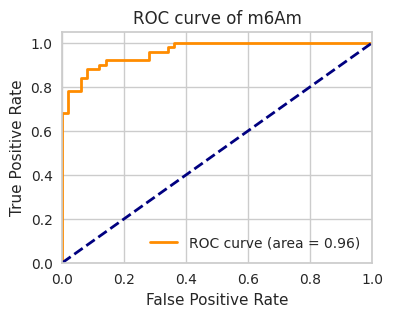

In [17]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thread = roc_curve(X_test.label.values, final_prob)
roc_auc= auc(fpr, tpr)

plt.figure(figsize=(4, 3))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of '+ mod_type)
plt.legend(loc="lower right")

if os.path.exists("./results/tables/img"):
    print("目录已存在")
else:
    os.mkdir("./results/tables/img")
plt.savefig("./results/tables/img/roc_curve_"+mod_type+".pdf", format='pdf',bbox_inches='tight')

plt.show()
